In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mystyle

ati = pd.read_csv('../data/atium.csv',index_col=0)

ati = ati[np.isfinite(ati.P.values)]   #Exclude stars without results
ati = ati[ati.chainflag < 2]            #Exclude stars without well constrained results
ati = ati[ati.KIC != 7680114]          #Exclude star that is clearly unevolved
print('We have {} stars'.format(len(ati)))

We have 54 stars


### Gyro Relation plots

In [7]:
ours = [0.5380376085895715, 0.5659898043933116, 0.321367381257116, 1.7055924587446913]

sun = {'age': 4.603,
       'P' : 25,
       'M' : 1,
       'R' : 1,
       'BV' : 0.656}
sun['bprp'] = 0.0981 + 1.4290*sun['BV'] -0.0269*sun['BV']**2 + 0.0061*sun['BV']**3

In [8]:
def gyro(tau, bv, a, b, c, d):
    return (tau*1000)**a * b*(bv - c)**d

In [9]:
from matplotlib.colors import ListedColormap
import seaborn as sns

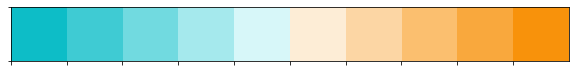

In [16]:
scmap = sns.diverging_palette(201, 38, s=99, l=70, n=10, center='light')
# scmap = sns.color_palette('colorblind', 3)
sns.palplot(scmap)
cmap = ListedColormap(scmap.as_hex())

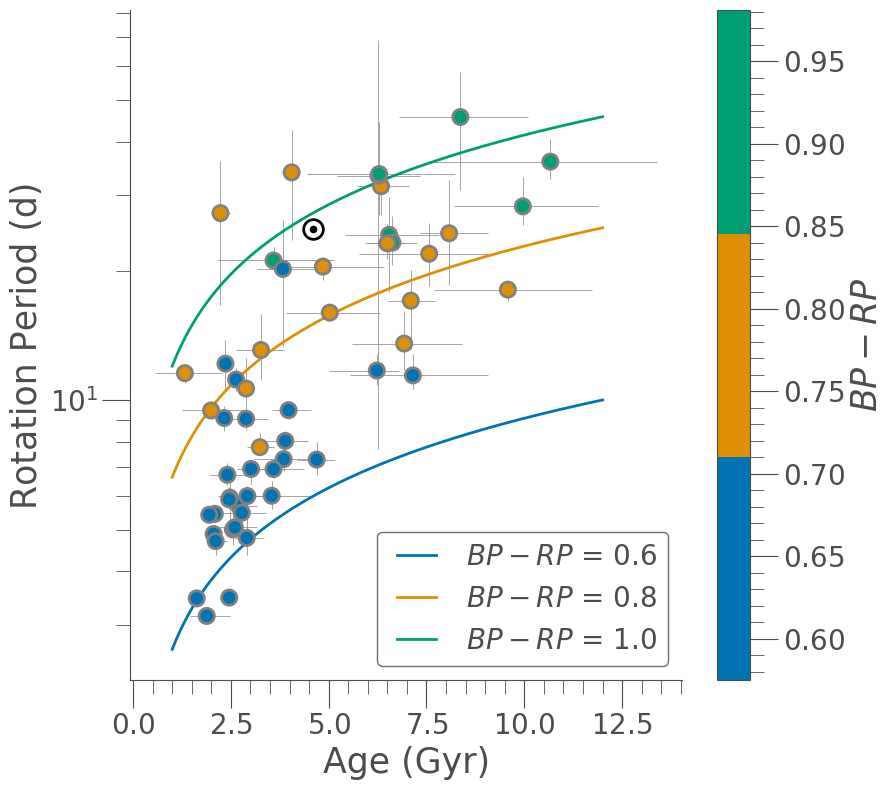

In [11]:
with plt.style.context(mystyle.ps):
    sns.set_palette('colorblind')
    fig, ax = plt.subplots(figsize=(9,8))
    c = ax.scatter(ati.age, ati.P, lw=2, ec='grey', c=ati.bprp, cmap=cmap, s=120, zorder=2)
    plt.errorbar(ati.age, ati.P, xerr=[ati.loage, ati.upage], yerr=[ati.l_P, ati.u_P],
                fmt='|', zorder=1, color='grey')

    tau = np.linspace(1., 12., 200)
    for col in [0.6, 0.8, 1.]:
        plt.plot(tau, gyro(tau, col, *ours), label=r'$BP-RP$ = {:.1f}'.format(col), 
                 lw=2, ls='-', zorder=1)

    plt.scatter(sun['age'],sun['P'], s=200, c='white', ec='k',lw=2)
    plt.scatter(sun['age'],sun['P'], s=20, c='k')

    ax.set_axisbelow(True)
    ax.set_xlabel('Age (Gyr)')
    ax.set_ylabel('Rotation Period (d)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='lower right', fontsize=20)
    fig.colorbar(c,label=r'$BP-RP$')
    ax.set_yscale('log')
    fig.tight_layout()
    plt.savefig('PvAge.pdf')

    plt.show()



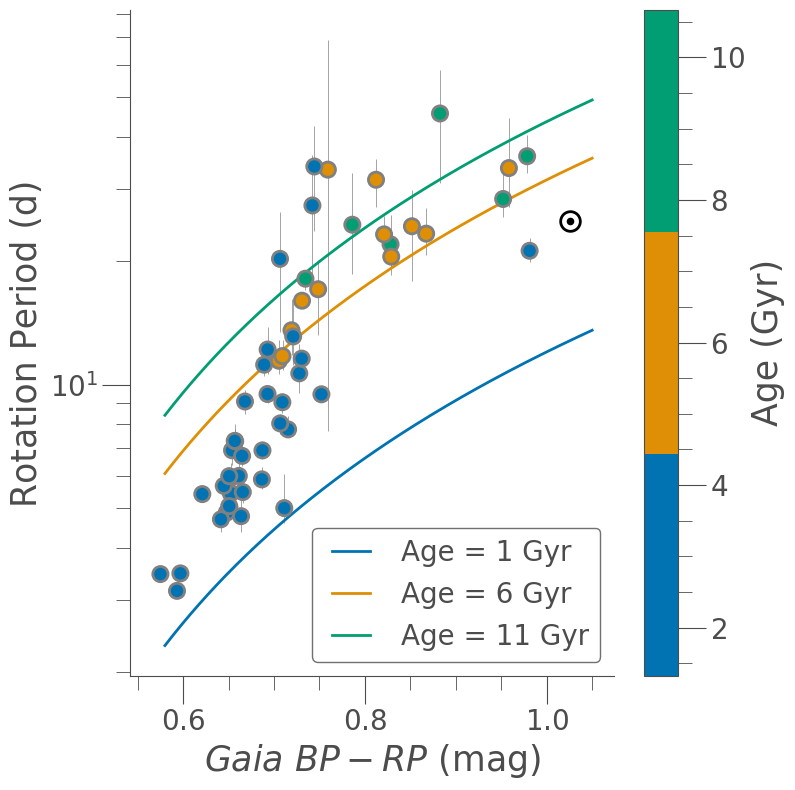

In [14]:
with plt.style.context(mystyle.ps):
    sns.set_palette('colorblind')
    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.scatter(ati.bprp, ati.P, lw=2, ec='grey', c=ati.age, cmap=cmap,s=120, zorder=2)
    plt.errorbar(ati.bprp, ati.P, xerr=ati.ebprp, yerr=[ati.l_P, ati.u_P],
                fmt='|', zorder=1, color='grey')

    col = np.linspace(0.58, 1.05, 200)
    for tau in [1., 6., 11.]:
        plt.plot(col, gyro(tau, col, *ours), label=r'Age = {:.0f} Gyr'.format(tau), 
                 lw=2, ls='-', zorder=1)

    plt.scatter(sun['bprp'],sun['P'], s=200, c='white', ec='k',lw=2,zorder=3)
    plt.scatter(sun['bprp'],sun['P'], s=20, c='k',zorder=3)

    ax.set_axisbelow(True)
    ax.set_xlabel(r'$Gaia$ $BP-RP$ (mag)')
    ax.set_ylabel('Rotation Period (d)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yscale('log')
    ax.legend(loc='lower right', fontsize=20)
    fig.colorbar(c, label='Age (Gyr)')
    fig.tight_layout()
    plt.savefig('PvCol.pdf')
    plt.show()



### Predicted Period plots

In [6]:
bv = pd.read_csv('../data/simbad_colours.txt',index_col=0, sep='|')
bv['KIC'] = [int(str(kic)[4:]) for kic in bv['KIC'].values]
bv.loc[bv['B'] == -99] = np.nan
bv.loc[bv['V'] == -99] = np.nan
bv['BV'] = bv.B - bv.V
bv = bv[['KIC','BV']]

kal = pd.merge(ati, bv, how='left', on='KIC')
kal = kal[np.isfinite(kal.BV.values)]
print('We have {} stars'.format(len(kal)))

We have 52 stars


In [7]:
def gyro(tau, bv, a, b, c, d):
    lnP = a * np.log(tau*1000) + np.log(b) + d*np.log(bv - c)
    return np.exp(lnP)

In [8]:
angus = [0.55, 0.40, 0.45, 0.31]
Ppred = gyro(kal.age, kal.BV, *angus)
sun['Ppred'] = gyro(sun['age'], sun['BV'], *angus)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [9]:
from uncertainties import ufloat
ratio = Ppred / kal.P
sun['ratio'] = sun['Ppred']/sun['P']
u_ratio = (Ppred / kal.P**2) * kal.u_P
l_ratio = (Ppred / kal.P**2) * kal.l_P

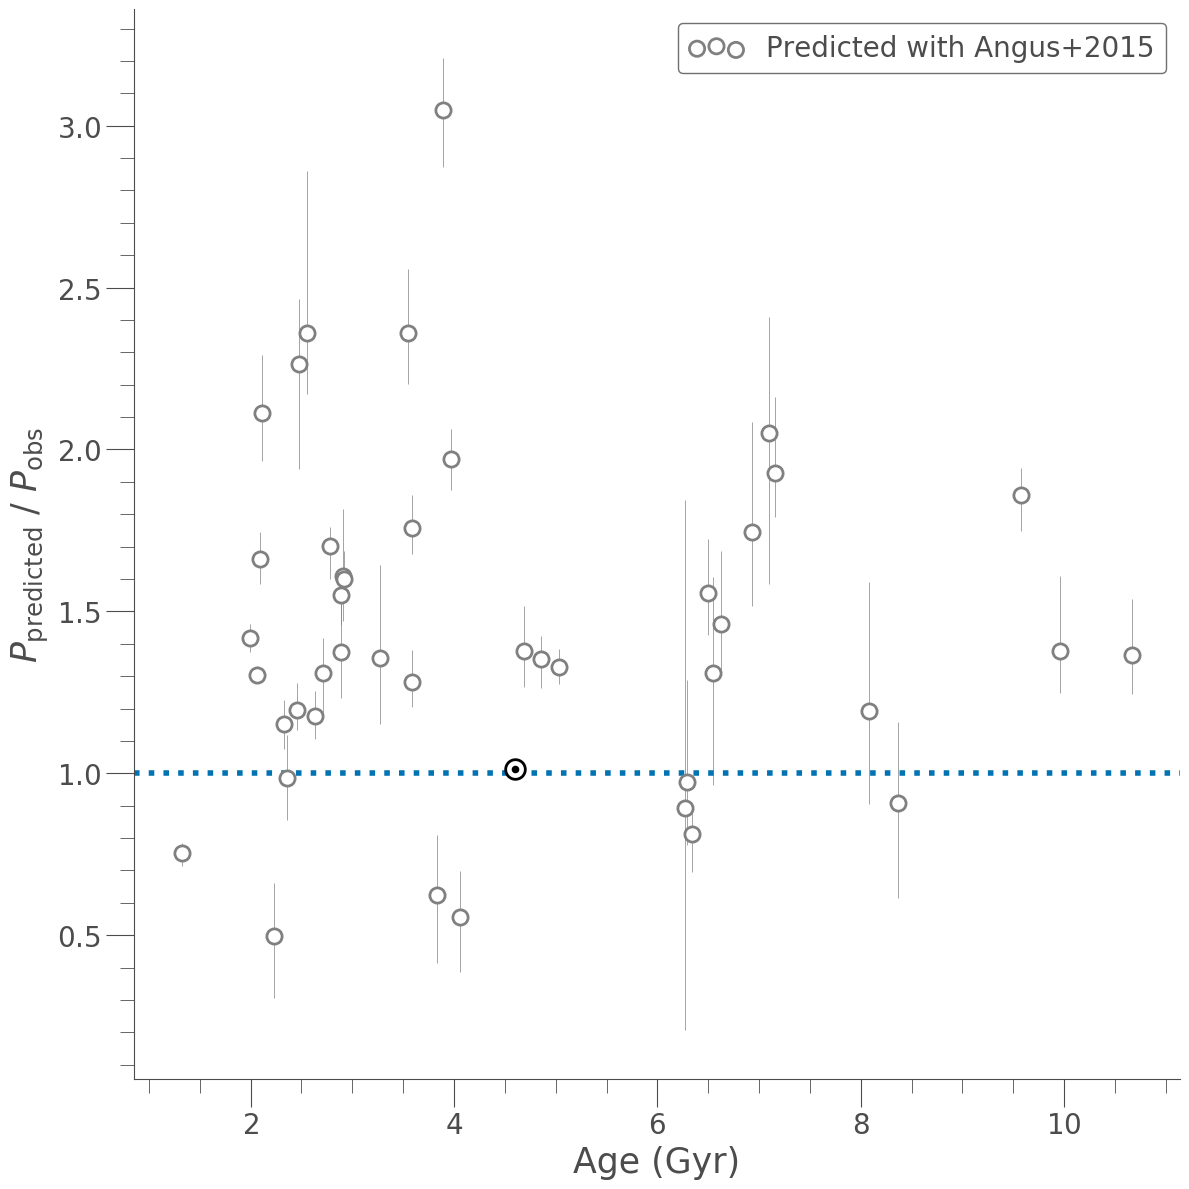

In [10]:
with plt.style.context(mystyle.ps):
    sns.set_palette('colorblind')
    fig, ax = plt.subplots(figsize=(12,12))
    c = ax.scatter(kal.age,  ratio, lw=2, ec='grey', c='white',s=120, zorder=2,
                  label='Predicted with Angus+2015')
    ax.errorbar(kal.age, ratio, yerr=[l_ratio, u_ratio],
                fmt='|', zorder=1, color='grey')

 
    ax.scatter(sun['age'],sun['ratio'], s=200, c='white', ec='k',lw=2,zorder=3)
    ax.scatter(sun['age'],sun['ratio'], s=20, c='k',zorder=3)

    ax.axhline(1., ls=':', lw=4, zorder=1)
    
    ax.set_axisbelow(True)
    ax.set_xlabel(r'Age (Gyr)')
    ax.set_ylabel(r'$P_{\rm predicted}$ / $P_{\rm obs}$')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='upper right', fontsize=20)
    fig.tight_layout()
    plt.savefig('PvPred.pdf')
    plt.show()



### Seismo plot

In [11]:
def epsilon( i, l, m):
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6

def lor(f, freq, h, w):
    return h / (1.0 + 4.0/w**2*(f - freq)**2)


Simulated data

In [12]:
locs = np.genfromtxt('../code/scripts/locs.txt')
pp = np.genfromtxt('../code/scripts/model.txt')
ff = np.genfromtxt('../code/scripts/freqs.txt')
lws = np.genfromtxt('../code/scripts/lws.txt')

In [13]:
nus = 1
i = np.deg2rad(45.)
d02 = 6.8
dnu = 102.
numax = 2200.

In [14]:
loc = locs[3,1]
lw = lws[3,1]
f = ff[(ff > loc-.03*dnu) & (ff < loc+.03*dnu)]


In [15]:
m0 = lor(f, loc, epsilon(i, 1, 0), lw)
m1 = lor(f, loc+nus, epsilon(i, 1, 1), lw)
mm1 = lor(f, loc-nus, epsilon(i, 1, -1), lw)

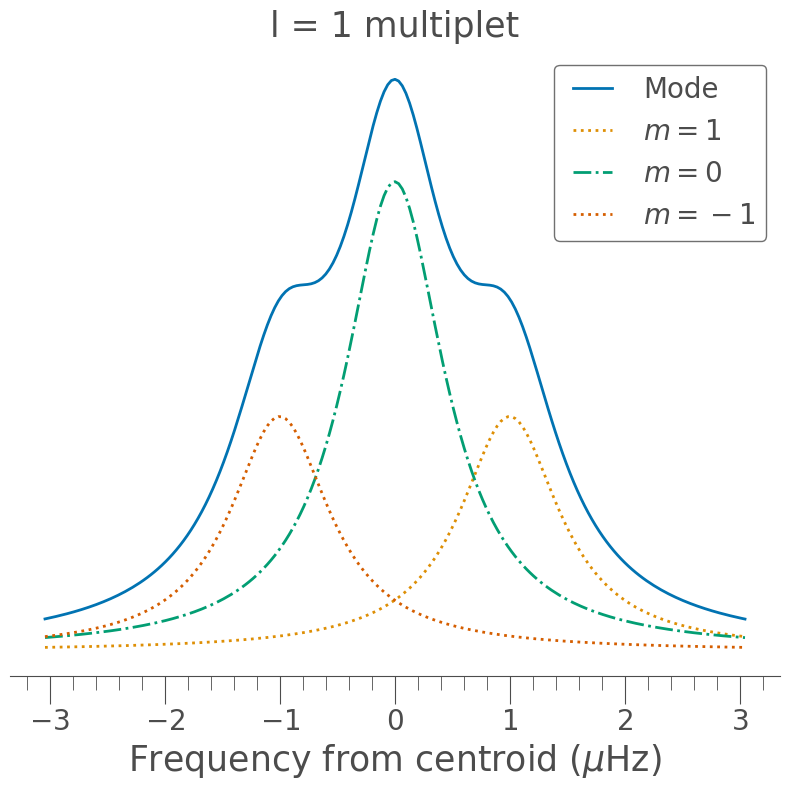

In [16]:
with plt.style.context(mystyle.ps):
    sns.set_palette('colorblind')
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    
    ax.plot(f-loc, m0 + m1 + mm1, lw=2, label=r'Mode')
    ax.plot(f-loc, m1, lw=2, ls=':', label=r'$m = 1$')
    ax.plot(f-loc, m0, lw=2, ls='-.', label=r'$m = 0$')
    ax.plot(f-loc, mm1, lw=2, ls=':', label=r'$m = -1$')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.legend()
    ax.set_xlabel(r'Frequency from centroid ($\mu \rm{Hz}$)')
    ax.set_title('l = 1 multiplet')
    ax.set_yticks([])
    fig.tight_layout()
    plt.savefig('l1modes.pdf')

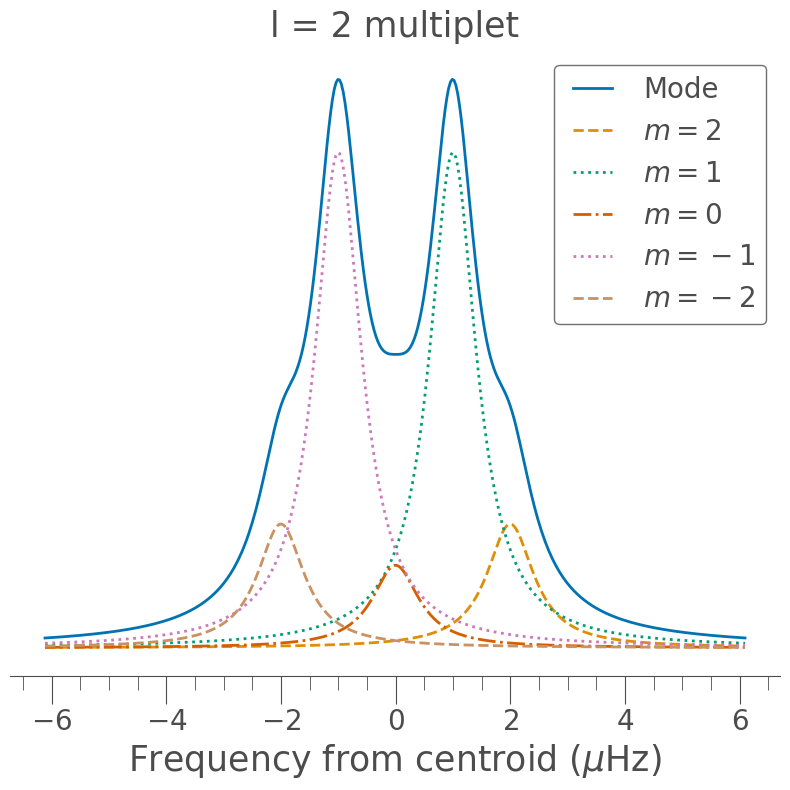

In [17]:
loc = locs[3,2]
lw = lws[3,2]
f = ff[(ff > loc-.06*dnu) & (ff < loc+.06*dnu)]

m0 = lor(f, loc, epsilon(i, 2, 0), lw)
m1 = lor(f, loc+nus, epsilon(i, 2, 1), lw)
mm1 = lor(f, loc-nus, epsilon(i, 2, -1), lw)
m2 = lor(f, loc+2*nus, epsilon(i, 2, 2), lw)
mm2 = lor(f, loc-2*nus, epsilon(i, 2, -2), lw)

with plt.style.context(mystyle.ps):
    sns.set_palette('colorblind')
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    
    ax.plot(f-loc, m0 + m1 + mm1 + m2 + mm2, lw=2, label=r'Mode')
    ax.plot(f-loc, m2, lw=2, ls='--', label=r'$m = 2$')
    ax.plot(f-loc, m1, lw=2, ls=':', label=r'$m = 1$')
    ax.plot(f-loc, m0, lw=2, ls='-.', label=r'$m = 0$')
    ax.plot(f-loc, mm1, lw=2, ls=':', label=r'$m = -1$')
    ax.plot(f-loc, mm2, lw=2, ls='--', label=r'$m = -2$')

    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.legend(loc='upper right')
    ax.set_title('l = 2 multiplet')
    ax.set_xlabel(r'Frequency from centroid ($\mu \rm{Hz}$)')
    ax.set_yticks([])
    fig.tight_layout()
    plt.savefig('l2modes.pdf')